In [1]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import sqlite3
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LinearRegression
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, f1_score, make_scorer, recall_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.pyplot import figure
from bs4 import BeautifulSoup
import time
import requests     # to get images
import shutil       # to save files locally
import datetime
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
import xgboost
from xgboost import XGBClassifier
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, ADASYN
import random
from random import randint
from sklearn.datasets import *
from IPython.display import Image, display_svg, SVG
import os
from sklearn.pipeline import Pipeline
from dtreeviz.trees import *
from sklearn.tree import plot_tree
os.environ["PATH"] += os.pathsep + "C:\\Users\\tmcro\\anaconda3\\pkgs\\graphviz-2.38-hfd603c8_2\\Library\\bin\\graphviz\\"
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.pipeline import Pipeline as imbpipeline # https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion


In [2]:
import pandas as pd
df = pd.read_csv('heart_2020_cleaned.csv')

target_name = "HeartDisease"
y = df[target_name]
X = df.drop(columns=[target_name])

In [3]:
# Scoring Metric
def my_custom_score(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    precision = cf[1,1] / sum(cf[:,1])
    recall    = cf[1,1] / sum(cf[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    rwf_score = (1+(2**2)) * ((precision * recall) / (((2**2) * precision) + recall))
    return rwf_score

my_scorer = make_scorer(my_custom_score, greater_is_better= True)

# Change class metric
class_metric = my_scorer

In [4]:
X.dtypes

BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object

In [5]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [6]:
categorical_columns

['Smoking',
 'AlcoholDrinking',
 'Stroke',
 'DiffWalking',
 'Sex',
 'AgeCategory',
 'Race',
 'Diabetic',
 'PhysicalActivity',
 'GenHealth',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

In [7]:
numerical_columns

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
catcols = [1,2,3,6,7,8,9,10,11,12,14,15,16]

In [10]:
# To get the column names from onehotencoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
checker = ohe.fit_transform(X_train[categorical_columns])


In [11]:
feature_names_categorical = ohe.get_feature_names(categorical_columns)

In [12]:
feature_names_categorical

array(['Smoking_No', 'Smoking_Yes', 'AlcoholDrinking_No',
       'AlcoholDrinking_Yes', 'Stroke_No', 'Stroke_Yes', 'DiffWalking_No',
       'DiffWalking_Yes', 'Sex_Female', 'Sex_Male', 'AgeCategory_18-24',
       'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39',
       'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54',
       'AgeCategory_55-59', 'AgeCategory_60-64', 'AgeCategory_65-69',
       'AgeCategory_70-74', 'AgeCategory_75-79',
       'AgeCategory_80 or older', 'Race_American Indian/Alaskan Native',
       'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other',
       'Race_White', 'Diabetic_No', 'Diabetic_No, borderline diabetes',
       'Diabetic_Yes', 'Diabetic_Yes (during pregnancy)',
       'PhysicalActivity_No', 'PhysicalActivity_Yes',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good', 'Asthma_No', 'Asthma_Yes',
       'KidneyDisease_No', 'KidneyDisease_Yes', 'SkinCancer_No',
      

### SMOTENC

In [13]:
Smote_NC = SMOTENC(categorical_features= catcols, random_state=42)

In [14]:
print(y_train.value_counts())
# Fit SMOTE to training data
X_train_resampled, y_train_resampled = Smote_NC.fit_resample(X_train, y_train)
# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts())

No     219418
Yes     20428
Name: HeartDisease, dtype: int64


No     219418
Yes    219418
Name: HeartDisease, dtype: int64


In [15]:
X_train = X_train_resampled
y_train = y_train_resampled

In [16]:
# Identify Processors
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

smoter = SMOTENC(categorical_features= categorical_columns, random_state= 0)
classifier = LogisticRegression(max_iter=500)

### Code Additions

In [17]:
# SOURCE: The origin of this confusion matrix code was found on medium, '
# from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            a = cf[0,0]
            b = cf[0,1]
            c = cf[1,0]
            d = cf[1,1]
            tn = ((a / (a+b))*100).round(2).astype(str) + '%'
            fp = ((b / (a+b))*100).round(2).astype(str) + '%'
            fn = ((c / (c+d))*100).round(2).astype(str) + '%'
            tp = ((d / (c+d))*100).round(2).astype(str) + '%'
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            rwf_score = (1+(2**2)) * ((precision * recall) / (((2**2) * precision) + recall))
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}\n\nRecall-Weighted F Score={:0.3f}".format(
                accuracy,precision,recall,f1_score, rwf_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages =  [tn,fp,fn,tp]
        # old = group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label', weight = 'bold')
        plt.xlabel('Predicted label' + stats_text, weight = 'bold')
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title,size = 20, weight = 'bold')

In [18]:
dfcols = ['Model', 'RWF Score', 'F1',  'Recall',  'Precision',  'Accuracy']
model_summary = pd.DataFrame(columns=dfcols)
model_summary

,Model,RWF Score,F1,Recall,Precision,Accuracy


In [19]:
# Define Result Saving Initial Function
def save_result(cf, model_name):
            global model_summary
            accuracy  = np.trace(cf) / float(np.sum(cf))
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            rwf_score = (1+(2**2)) * ((precision * recall) / (((2**2) * precision) + recall))
            row = [(model_name, rwf_score, f1_score, recall, precision, accuracy)]
            res = pd.DataFrame(columns = dfcols, data = row)
            yeep = [model_summary, res]
            model_summary = pd.concat(yeep)
            model_summary = model_summary.sort_values('RWF Score', ascending = False)
            model_summary = model_summary.drop_duplicates()
            return model_summary.round(3)

In [20]:
def run_model(model, model_name):
    model.fit(X_train, y_train)
    model_prediction = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, model_prediction)
    save_result(cf_matrix, model_name)
    cf = make_confusion_matrix(cf_matrix)
    return model_summary

### Models to Run 

In [25]:
# Initial Models
init_decision_tree = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=0, max_depth=3))
log_reg = make_pipeline(preprocessor, LogisticRegression(random_state=0))
decisionTree = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth=5, random_state=0))
random_forest = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=50, random_state=0))
baggedTrees = make_pipeline(preprocessor, BaggingClassifier(DecisionTreeClassifier(), n_estimators=50, random_state=0))
extraTrees = make_pipeline(preprocessor, ExtraTreesClassifier(n_estimators=50, random_state=0))
knn = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=5))
xgBoost = make_pipeline(preprocessor, XGBClassifier(n_estimators=50, random_state=0))


,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.501597,0.337694,0.741541,0.218628,0.747326
0,Initial Decision Tree,0.412634,0.246150,0.751476,0.147180,0.600158


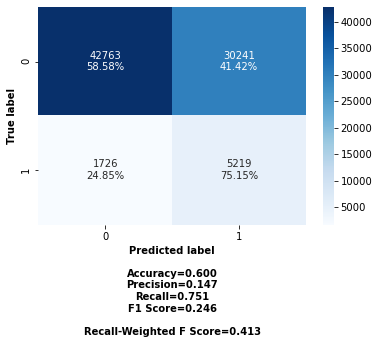

In [26]:
run_model(init_decision_tree, 'Initial Decision Tree')

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.501597,0.337694,0.741541,0.218628,0.747326
0,Initial Decision Tree,0.412634,0.246150,0.751476,0.147180,0.600158


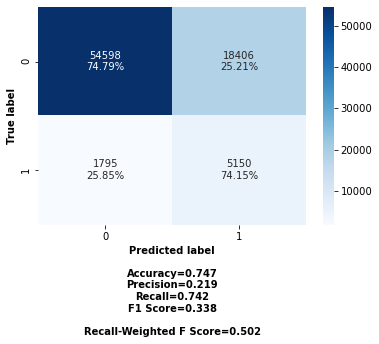

In [27]:
run_model(log_reg, 'Logistic Regression')

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.501597,0.337694,0.741541,0.218628,0.747326
0,Decision Tree,0.441529,0.276928,0.731317,0.170803,0.668251
0,Initial Decision Tree,0.412634,0.246150,0.751476,0.147180,0.600158


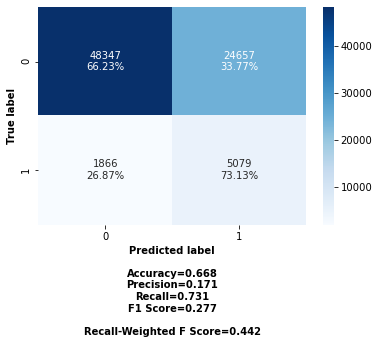

In [28]:
run_model(decisionTree, 'Decision Tree')

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.501597,0.337694,0.741541,0.218628,0.747326
0,Decision Tree,0.441529,0.276928,0.731317,0.170803,0.668251
0,Initial Decision Tree,0.412634,0.246150,0.751476,0.147180,0.600158
0,Random Forest,0.304572,0.288472,0.316343,0.265114,0.864439


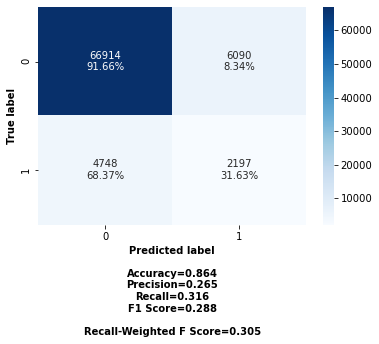

In [29]:
run_model(random_forest, 'Random Forest')

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.501597,0.337694,0.741541,0.218628,0.747326
0,Decision Tree,0.441529,0.276928,0.731317,0.170803,0.668251
0,Initial Decision Tree,0.412634,0.246150,0.751476,0.147180,0.600158
0,Random Forest,0.304572,0.288472,0.316343,0.265114,0.864439
0,Bagged Trees,0.256132,0.252925,0.258315,0.247756,0.867440


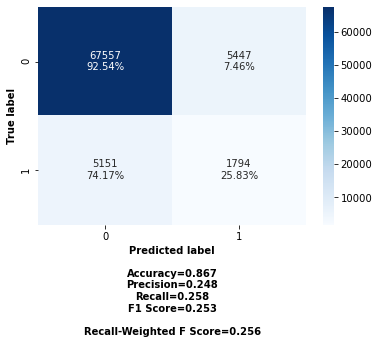

In [30]:
run_model(baggedTrees, 'Bagged Trees')

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.501597,0.337694,0.741541,0.218628,0.747326
0,Decision Tree,0.441529,0.276928,0.731317,0.170803,0.668251
0,Initial Decision Tree,0.412634,0.246150,0.751476,0.147180,0.600158
0,Random Forest,0.304572,0.288472,0.316343,0.265114,0.864439
0,Extra Trees,0.300333,0.273155,0.321670,0.237357,0.851293
0,Bagged Trees,0.256132,0.252925,0.258315,0.247756,0.867440


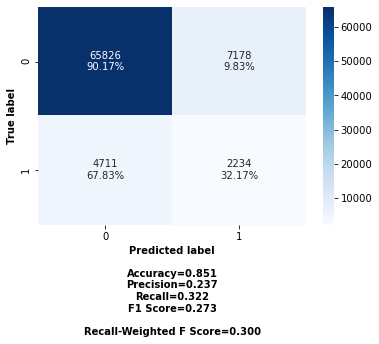

In [31]:
run_model(extraTrees, 'Extra Trees')

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.501597,0.337694,0.741541,0.218628,0.747326
0,Decision Tree,0.441529,0.276928,0.731317,0.170803,0.668251
0,Initial Decision Tree,0.412634,0.246150,0.751476,0.147180,0.600158
0,XGBoost,0.371405,0.343849,0.392369,0.306008,0.869917
0,Random Forest,0.304572,0.288472,0.316343,0.265114,0.864439
0,Extra Trees,0.300333,0.273155,0.321670,0.237357,0.851293
0,Bagged Trees,0.256132,0.252925,0.258315,0.247756,0.867440


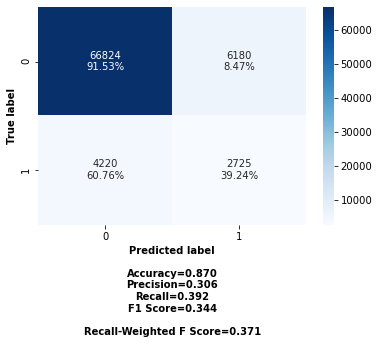

In [32]:
run_model(xgBoost, 'XGBoost')

## Iterate the best



In [33]:
log_reg['logisticregression'].get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [34]:
# Define Grid
rf_grid = [{'logisticregression__C': [1, 2],
        'logisticregression__penalty': ['l2', 'none'],
        'logisticregression__solver': ['newton-cg', 'lbfgs','sag']}]

In [35]:
logreg_gridsearch = GridSearchCV(estimator=log_reg, param_grid=rf_grid, scoring=class_metric, cv=3)

In [36]:
log_reg.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'logisticregression', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__one-hot-encoder', 'columntransformer__standard_scaler', 'columntransformer__one-hot-encoder__categories', 'columntransformer__one-hot-encoder__drop', 'columntransformer__one-hot-encoder__dtype', 'columntransformer__one-hot-encoder__handle_unknown', 'columntransformer__one-hot-encoder__sparse', 'columntransformer__standard_scaler__copy', 'columntransformer__standard_scaler__with_mean', 'columntransformer__standard_scaler__with_std', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__m

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.501597,0.337694,0.741541,0.218628,0.747326
0,Logistic Regression with Grid Search,0.501412,0.337529,0.741397,0.218502,0.747189
0,Decision Tree,0.441529,0.276928,0.731317,0.170803,0.668251
0,Initial Decision Tree,0.412634,0.246150,0.751476,0.147180,0.600158
0,XGBoost,0.371405,0.343849,0.392369,0.306008,0.869917
0,Random Forest,0.304572,0.288472,0.316343,0.265114,0.864439
0,Extra Trees,0.300333,0.273155,0.321670,0.237357,0.851293
0,Bagged Trees,0.256132,0.252925,0.258315,0.247756,0.867440


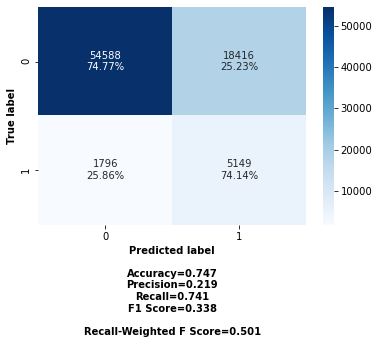

In [37]:
#logreg_gridsearch.fit(X_train, y_train)
run_model(logreg_gridsearch, 'Logistic Regression with Grid Search')

### Winner: Logistic Regression

In [38]:
log_reg.named_steps

{'columntransformer': ColumnTransformer(transformers=[('one-hot-encoder',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  ['Smoking', 'AlcoholDrinking', 'Stroke',
                                   'DiffWalking', 'Sex', 'AgeCategory', 'Race',
                                   'Diabetic', 'PhysicalActivity', 'GenHealth',
                                   'Asthma', 'KidneyDisease', 'SkinCancer']),
                                 ('standard_scaler', StandardScaler(),
                                  ['BMI', 'PhysicalHealth', 'MentalHealth',
                                   'SleepTime'])]),
 'logisticregression': LogisticRegression(random_state=0)}

In [39]:
coefs = log_reg['logisticregression'].coef_
coefs = list(coefs[0])
len(coefs)

50

In [40]:
numerical_columns

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

In [41]:
cat_list= list(feature_names_categorical)

In [42]:
all_cats = cat_list + numerical_columns

In [43]:
all_cats

['Smoking_No',
 'Smoking_Yes',
 'AlcoholDrinking_No',
 'AlcoholDrinking_Yes',
 'Stroke_No',
 'Stroke_Yes',
 'DiffWalking_No',
 'DiffWalking_Yes',
 'Sex_Female',
 'Sex_Male',
 'AgeCategory_18-24',
 'AgeCategory_25-29',
 'AgeCategory_30-34',
 'AgeCategory_35-39',
 'AgeCategory_40-44',
 'AgeCategory_45-49',
 'AgeCategory_50-54',
 'AgeCategory_55-59',
 'AgeCategory_60-64',
 'AgeCategory_65-69',
 'AgeCategory_70-74',
 'AgeCategory_75-79',
 'AgeCategory_80 or older',
 'Race_American Indian/Alaskan Native',
 'Race_Asian',
 'Race_Black',
 'Race_Hispanic',
 'Race_Other',
 'Race_White',
 'Diabetic_No',
 'Diabetic_No, borderline diabetes',
 'Diabetic_Yes',
 'Diabetic_Yes (during pregnancy)',
 'PhysicalActivity_No',
 'PhysicalActivity_Yes',
 'GenHealth_Excellent',
 'GenHealth_Fair',
 'GenHealth_Good',
 'GenHealth_Poor',
 'GenHealth_Very good',
 'Asthma_No',
 'Asthma_Yes',
 'KidneyDisease_No',
 'KidneyDisease_Yes',
 'SkinCancer_No',
 'SkinCancer_Yes',
 'BMI',
 'PhysicalHealth',
 'MentalHealth',
 'S

In [44]:
log_reg['logisticregression'].coef_

array([[-4.05333675e-01, -2.90920559e-02,  3.37922741e-01,
        -7.72348472e-01, -6.18184131e-01,  1.83758400e-01,
        -3.03145729e-01, -1.31280001e-01, -6.00230712e-01,
         1.65804981e-01, -2.16451588e+00, -2.27540768e+00,
        -2.01627123e+00, -1.44242048e+00, -8.19559992e-01,
        -4.64338740e-01,  2.44673437e-01,  6.01561770e-01,
         1.01634869e+00,  1.28097544e+00,  1.61177442e+00,
         1.81754057e+00,  2.17521394e+00, -6.26414042e-01,
        -7.51741889e-01,  6.32556488e-02,  3.01197732e-01,
        -4.49489479e-01,  1.02876630e+00,  5.26667578e-01,
        -4.80360117e-01,  1.00643036e+00, -1.48716355e+00,
        -2.57080607e-01, -1.77345124e-01, -1.34099153e+00,
         6.31534785e-01,  2.00928726e-03,  9.89670893e-01,
        -7.16649164e-01, -2.70863747e-01, -1.63561984e-01,
        -2.54662829e-01, -1.79762902e-01, -1.43987311e-01,
        -2.90438420e-01,  9.58713097e-02, -1.40068493e-02,
         9.92067232e-02, -6.18929764e-02]])

In [45]:
data1 = log_reg['logisticregression'].coef_
cols = all_cats
data = pd.DataFrame(data1, columns=cols)
data = data.T
data

,0
Smoking_No,-0.405334
Smoking_Yes,-0.029092
AlcoholDrinking_No,0.337923
AlcoholDrinking_Yes,-0.772348
Stroke_No,-0.618184
Stroke_Yes,0.183758
DiffWalking_No,-0.303146
DiffWalking_Yes,-0.131280
Sex_Female,-0.600231
Sex_Male,0.165805


In [46]:
data = data.reset_index()

Text(0.5, 1.0, 'Logistic Regression Coefficients')

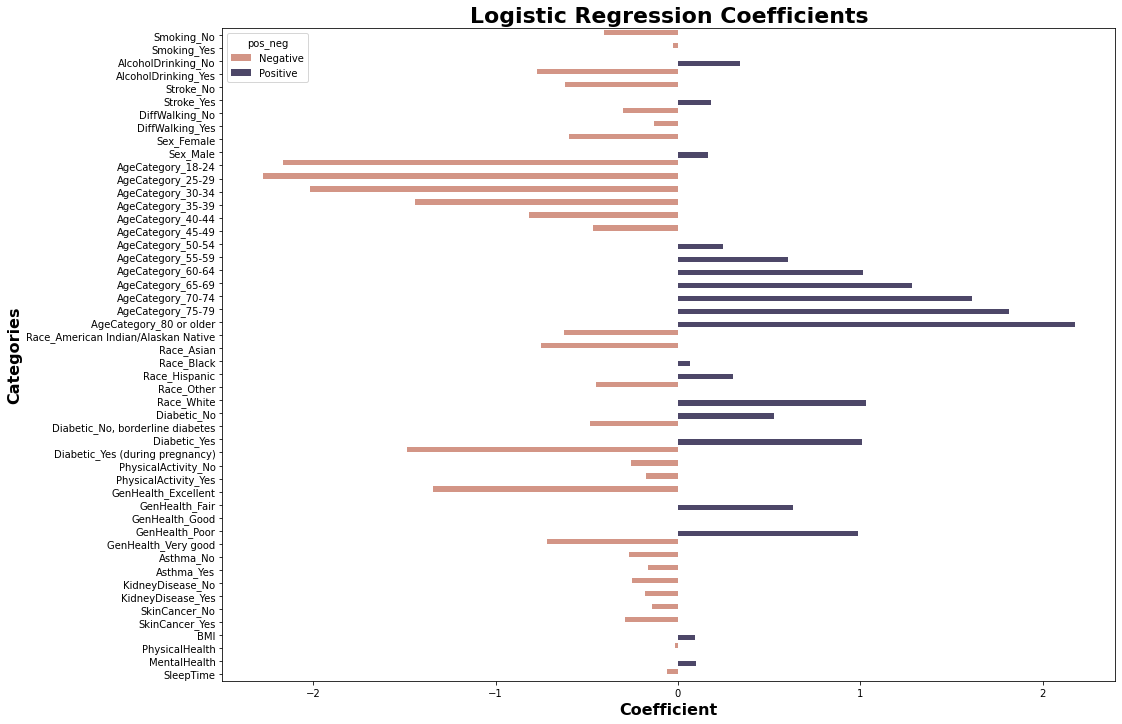

In [55]:
plt.figure(figsize=(16,12))

conds = [(data[0] > 0),
        (data[0] < 0)]

vals = ['Positive', 'Negative']
data['pos_neg'] = np.select(conds, vals)
color_dict = {'Positive': '#49416D', 'Negative': '#E08D79'}

ax = sns.barplot(x=0,y= 'index', data=data, hue = 'pos_neg', palette= color_dict)
plt.ylabel('Categories', size = 16, weight = 'bold')
plt.xlabel('Coefficient', size = 16, weight = 'bold')
plt.title('Logistic Regression Coefficients', size = 22, weight = 'bold')
